## 1: Setup of the environment

pyton module installation if necessary

In [1]:
!pip install pandas
!pip install numpy
!pip install scipy
!pip install matplotlib

all imports

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import pandas as pd
from scipy.ndimage import gaussian_filter
from scipy import stats

Data reading and preparation

In [3]:
def timeToSec(x):
    m,s = x.split(':')
    return int(s) + (int(m)*60)
def loopOverSeries(x):
    return x.apply(lambda i: checkCoordinates(i))
def checkCoordinates(x):
    # print(x)
    if type(x) == type(' '):
        return list(map(int,x.split(' ')))
    elif type(x) == type([]):
        return x
    return []
    
#list of variables to test
variables = ['Task completion time','Total number of taps','Number of erroneous inputs']

#Read data from csv file
data = pd.read_csv('study_results.csv')

#convert task completion times in data from str to int (represented in secounds)
data['Task completion time'] = data['Task completion time'].apply(lambda x: timeToSec(x))

#fix empty coordinate representation in data
list_of_columns = ['Tap x coord.','Tap y coord.','Error x coord.','Error y coord.']
data[list_of_columns] = data[list_of_columns].apply(lambda x: (loopOverSeries(x)))

## 2: Heatmaps

Read all the touch and erroneous touch coordinates from data

In [4]:

# [ [list of x coord.] , [list of y coord.] ]
direct_tap = [[],[]]
direct_tap[0] = [x for sublist in data.loc[data['Task type'] == 'direct', 'Tap x coord.'] for x in sublist]
direct_tap[1] = [y for sublist in data.loc[data['Task type'] == 'direct', 'Tap y coord.'] for y in sublist]
indirect_tap = [[],[]]
indirect_tap[0] = [x for sublist in data.loc[data['Task type'] == 'indirect', 'Tap x coord.'] for x in sublist]
indirect_tap[1] = [y for sublist in data.loc[data['Task type'] == 'indirect', 'Tap y coord.'] for y in sublist]
direct_err = [[],[]]
direct_err[0] = [x for sublist in data.loc[data['Task type'] == 'direct', 'Error x coord.'] for x in sublist]
direct_err[1] = [y for sublist in data.loc[data['Task type'] == 'direct', 'Error y coord.'] for y in sublist]
indirect_err = [[],[]]
indirect_err[0] = [x for sublist in data.loc[data['Task type'] == 'indirect', 'Error x coord.'] for x in sublist]
indirect_err[1] = [y for sublist in data.loc[data['Task type'] == 'indirect', 'Error y coord.'] for y in sublist]

Plot the headmaps from the read data

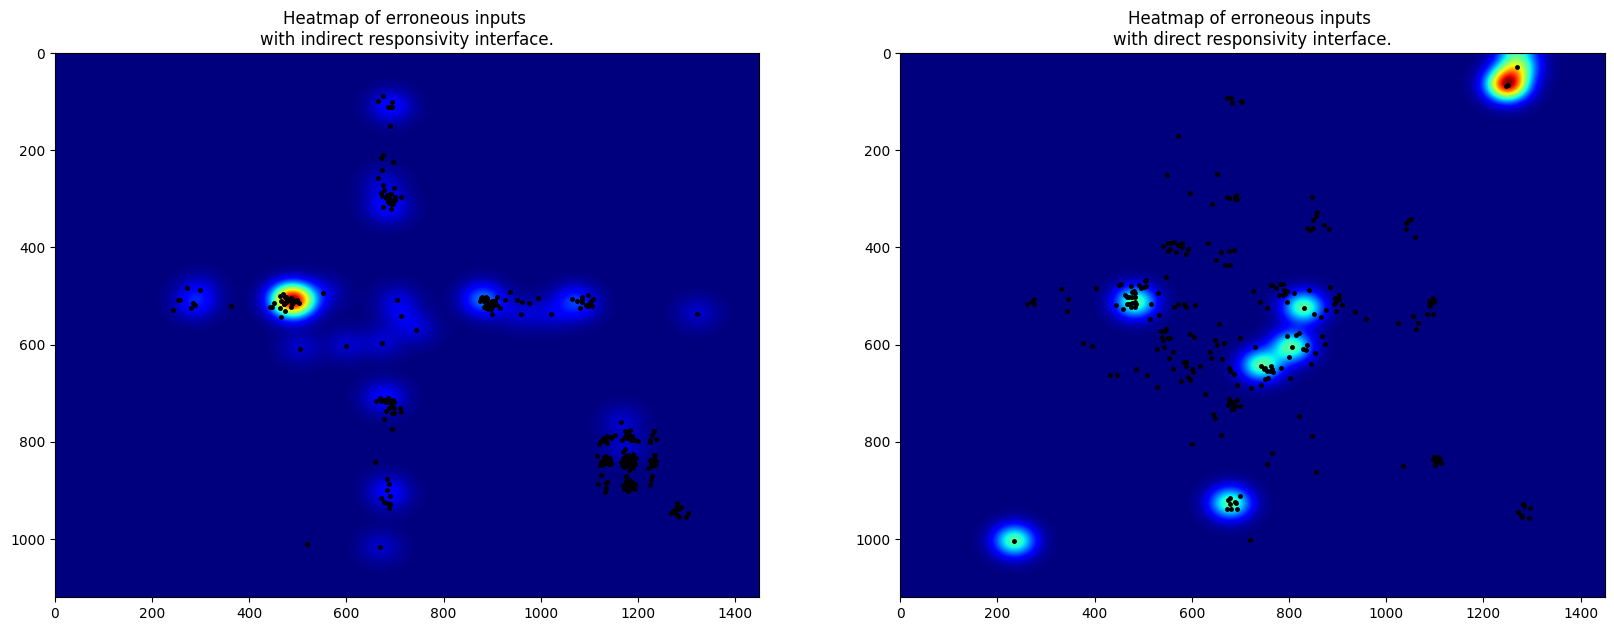

In [5]:
def heatmap(err, sigma, bins = 1000):
    heatmap, xedges, yedges = np.histogram2d(err[0], err[1], bins=bins, range=[[0,1450],[0,1120]])
    heatmap = gaussian_filter(heatmap, sigma=sigma)

    extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
    return heatmap.T, extent

plt.figure(figsize=(20,40))
s = 20

#Heatmap of indirect variant
plt.subplot(221)
plt.plot(indirect_tap[0], indirect_tap[1], 'k.', markersize=5)
hMap1, extent1 = heatmap(indirect_err, s)
plt.imshow(hMap1, extent=extent1, origin='lower', cmap=cm.jet)
plt.title("Heatmap of erroneous inputs \nwith indirect responsivity interface.")
plt.gca().invert_yaxis()

#Heatmap of direct variant
plt.subplot(222)
plt.plot(direct_tap[0], direct_tap[1], 'k.', markersize=5)
hMap2, extent2 = heatmap(direct_err, s)
plt.imshow(hMap2, extent=extent2, origin='lower', cmap=cm.jet)
plt.title("Heatmap of erroneous inputs \nwith direct responsivity interface.")
plt.gca().invert_yaxis()

plt.show()

## 3: Properties of the data

### Plotting data

----------------------------------------------------------------------------------------------------
Statistics on task completion time
              mean        std        sem     ci95_hi     ci95_lo    y_error
Task type                                                                  
direct     159.375  37.720542  13.336226  185.514002  133.235998  26.139002
indirect   147.875  28.341980  10.020403  167.514990  128.235010  19.639990
----------------------------------------------------------------------------------------------------
Statistics on total number of taps
             mean        std       sem    ci95_hi    ci95_lo    y_error
Task type                                                              
direct     32.375   8.879149  3.139253  38.527936  26.222064   6.152936
indirect   46.500  16.044581  5.672616  57.618327  35.381673  11.118327
----------------------------------------------------------------------------------------------------
Statistics on number of erroneous i

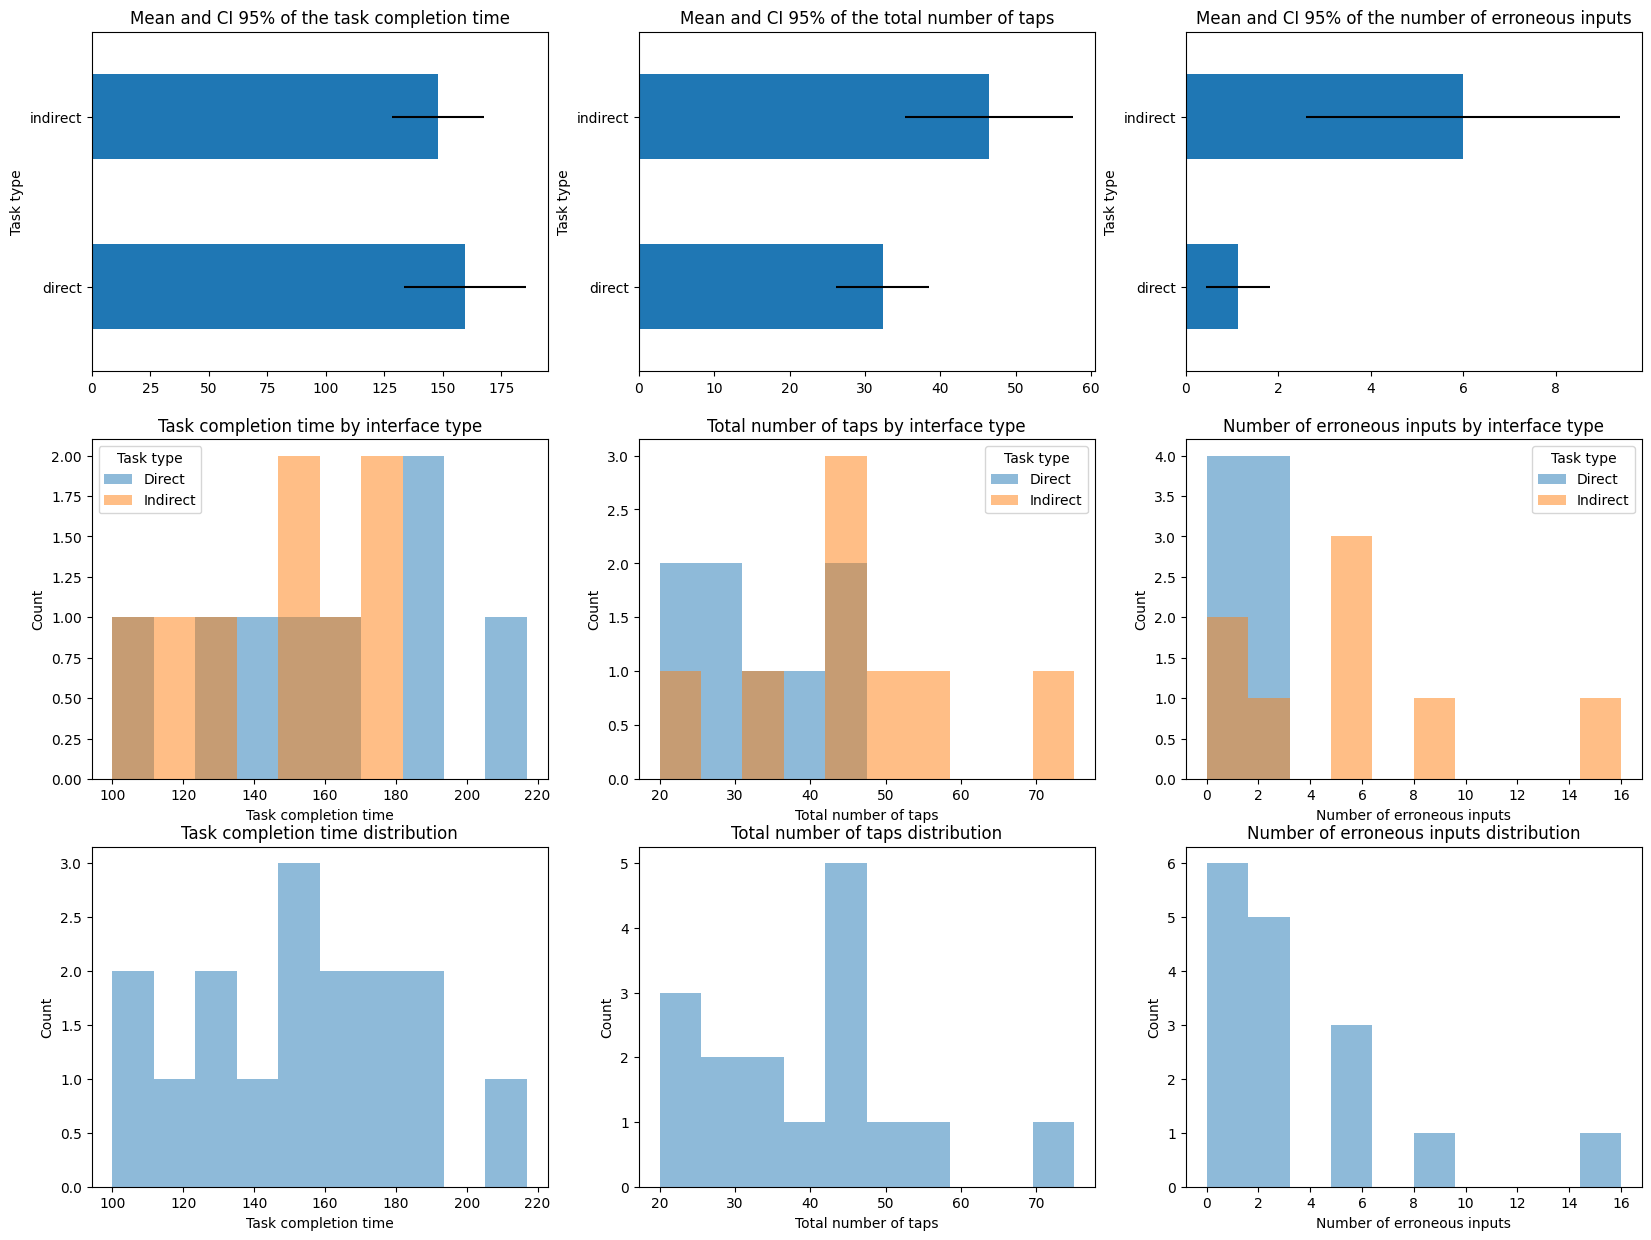

In [6]:
fig, axs = plt.subplots(3,len(variables))
width = 20
height = 15
fig.set_size_inches(width,height)
print('-'*100)
for i in range(len(variables)):
    hist_min = data[variables[i]].min()
    hist_max = data[variables[i]].max()
    variable_stats = data.groupby(['Task type'])[variables[i]].agg(['mean', 'std', 'sem'])
    variable_stats['ci95_hi'] = variable_stats['mean'] + 1.96* variable_stats['sem']
    variable_stats['ci95_lo'] = variable_stats['mean'] - 1.96* variable_stats['sem']
    variable_stats['y_error'] = (variable_stats['ci95_hi'] - variable_stats['ci95_lo'])/2
    print("Statistics on "+ variables[i].lower())
    print(variable_stats)
    print('-'*100)

    variable_stats.plot(kind='barh',y = 'mean', legend= False, title="Mean and CI 95% of the "+variables[i].lower(),xerr="y_error", ax=axs[0,i])

    axs[1,i].hist(data.loc[data['Task type'] == 'direct', variables[i]], alpha=0.5, label='Direct',range=(hist_min,hist_max))
    axs[1,i].hist(data.loc[data['Task type'] == 'indirect', variables[i]], alpha=0.5, label='Indirect',range=(hist_min,hist_max))
    axs[1,i].set_title(variables[i]+' by interface type')
    axs[1,i].set_xlabel(variables[i])
    axs[1,i].set_ylabel('Count')
    axs[1,i].legend(title='Task type')
    axs[2,i].hist(data[variables[i]], alpha=0.5, range=(hist_min,hist_max))
    axs[2,i].set_title(variables[i]+' distribution')
    axs[2,i].set_xlabel(variables[i])
    axs[2,i].set_ylabel('Count')

#display plot
plt.show()

### Levene's and Shapiro-Wilk test

In [7]:
a = 0.05 #significance level
shapiro_tests = []
levene_tests = []
final_tests = []
for x in variables:
    shapiro_tests.append(stats.shapiro(data[x]))
    levene_tests.append(stats.levene(data.loc[data['Task type'] == 'direct', x],data.loc[data['Task type'] == 'indirect', x]))
for i, x in enumerate(variables):
    print(x+':\n\tShapiro-Wilk p-value: '+str(shapiro_tests[i].pvalue)+'\tLevene p-value: '+str(levene_tests[i].pvalue)+'\n\t', end="")

    if shapiro_tests[i].pvalue<0.05 or levene_tests[i].pvalue<0.05:
        print("======> For the variable ["+variables[i]+"] run Wilcoxon signed rank test...\n\t\t Wilcoxon p-value: ", end='')
        final_tests.append(stats.wilcoxon(data.loc[data['Task type'] == 'direct', x], data.loc[data['Task type'] == 'indirect', x]))
    else:
        print("======> For the variable ["+variables[i]+"] run Paired t-test...\n\t\t Paired T-test p-value: ", end='')
        final_tests.append(stats.ttest_rel(data.loc[data['Task type'] == 'direct', x], data.loc[data['Task type'] == 'indirect', x]))
    print(final_tests[i].pvalue)
    
    result = ""
    if final_tests[i].pvalue > a:
        result = "WE FAILED TO REJECT THE NULL HYPOTHESIS ON THE "+x.upper()
    else:
        result = "WE CAN CONFIDENTLY REJECT THE NULL HYPOTHESIS ON THE "+x.upper()
    print("    |"+(len(result)+6)*'-'+"|")
    print("    |   "+result+"   |")
    print("    |"+(len(result)+6)*"-"+"|")


Task completion time:
	Shapiro-Wilk p-value: 0.9631024599075317	Levene p-value: 0.5079023847327878
	======> For the variable [Task completion time] run Paired t-test...
		 Paired T-test p-value: 0.5396844354367989
    |-------------------------------------------------------------------------|
    |   WE FAILED TO REJECT THE NULL HYPOTHESIS ON THE TASK COMPLETION TIME   |
    |-------------------------------------------------------------------------|
Total number of taps:
	Shapiro-Wilk p-value: 0.34086811542510986	Levene p-value: 0.4436412706413655
	======> For the variable [Total number of taps] run Paired t-test...
		 Paired T-test p-value: 0.07357029159660457
    |-------------------------------------------------------------------------|
    |   WE FAILED TO REJECT THE NULL HYPOTHESIS ON THE TOTAL NUMBER OF TAPS   |
    |-------------------------------------------------------------------------|
Number of erroneous inputs:
	Shapiro-Wilk p-value: 0.0012692194432020187	Levene p-value: 0